<a href="https://colab.research.google.com/github/JUANJO2410/CHALLENGE_TELECOM2/blob/main/TelecomX_LATAM_Challenge2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#📌 Extracción

Snapshot guardado en telecomx_flat_renombrado.parquet

========== LogReg ==========
              precision    recall  f1-score   support

           0     0.8446    0.8892    0.8663      1552
           1     0.6409    0.5472    0.5904       561

    accuracy                         0.7984      2113
   macro avg     0.7427    0.7182    0.7283      2113
weighted avg     0.7905    0.7984    0.7930      2113

ROC‑AUC: 0.8403


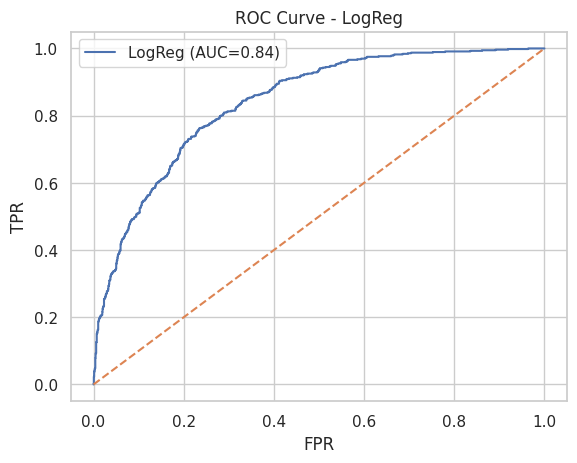


========== RandomForest ==========
              precision    recall  f1-score   support

           0     0.8311    0.8911    0.8601      1552
           1     0.6236    0.4991    0.5545       561

    accuracy                         0.7870      2113
   macro avg     0.7274    0.6951    0.7073      2113
weighted avg     0.7760    0.7870    0.7789      2113

ROC‑AUC: 0.8241


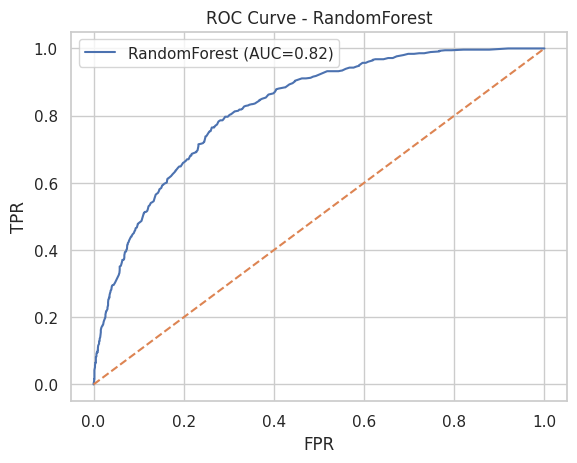


========== XGBoost ==========
              precision    recall  f1-score   support

           0     0.8445    0.8853    0.8644      1552
           1     0.6337    0.5490    0.5883       561

    accuracy                         0.7960      2113
   macro avg     0.7391    0.7172    0.7264      2113
weighted avg     0.7885    0.7960    0.7911      2113

ROC‑AUC: 0.8396


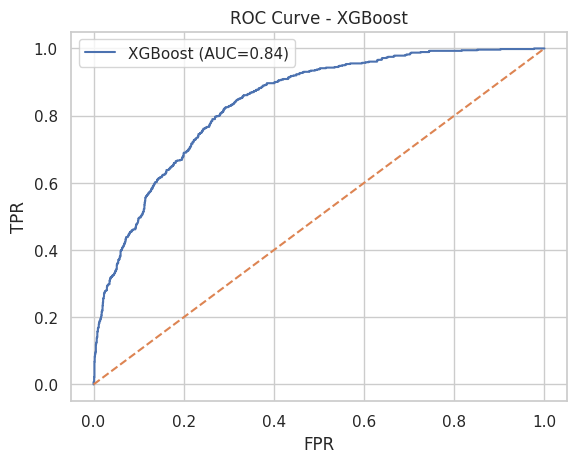

In [ ]:
# ================================================================
#  Pipeline TelecomX: Limpieza → Preprocesamiento → Modelos
# ================================================================
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt

# ---------------------------------------------------------------
# 1) Carga de datos
# ---------------------------------------------------------------
URL_JSON = (
    "https://github.com/alura-cursos/challenge2-data-science-LATAM/raw/main/TelecomX_Data.json"
)
df_raw = pd.read_json(URL_JSON)

def flatten_df(df, sep="_"):
    df = df.copy()
    for col in [c for c in df.columns if df[c].apply(lambda x: isinstance(x, list)).any()]:
        df = df.explode(col, ignore_index=True)
    while True:
        dict_cols = [c for c in df.columns if df[c].apply(lambda x: isinstance(x, dict)).any()]
        if not dict_cols:
            break
        for col in dict_cols:
            norm = pd.json_normalize(df[col]).add_prefix(f"{col}{sep}")
            df = pd.concat(
                [df.drop(columns=[col]).reset_index(drop=True), norm.reset_index(drop=True)],
                axis=1,
            )
    return df

df_flat = flatten_df(df_raw).reset_index(drop=True)

# ---------------------------------------------------------------
# 2) Conversión a float + imputación de cargos
# ---------------------------------------------------------------
for col in ["account_Charges.Monthly", "account_Charges.Total"]:
    df_flat[col] = (
        df_flat[col].replace(r"^\s*$", np.nan, regex=True).astype(float)
    )
imputer = SimpleImputer(strategy="median")
df_flat[["account_Charges.Monthly", "account_Charges.Total"]] = imputer.fit_transform(
    df_flat[["account_Charges.Monthly", "account_Charges.Total"]]
)

# ---------------------------------------------------------------
# 3) Renombrado de columnas
# ---------------------------------------------------------------
rename_cols = {
    "customerID":                 "ID_CLIENTE",
    "Churn":                      "CHURN",
    "customer_gender":            "GENERO_CLIENTE",
    "customer_SeniorCitizen":     "CLIENTE_SENIOR",
    "customer_Partner":           "CLIENTE_PARTNER",
    "customer_Dependents":        "CLIENTE_DEPENDIENTE",
    "customer_tenure":            "ANTIGUEDAD_CLIENTE",
    "phone_PhoneService":         "SERVICIO_TELEFONO",
    "phone_MultipleLines":        "MULTIPLES_LINEAS",
    "internet_InternetService":   "SERVICIO_INET",
    "internet_OnlineSecurity":    "SEGURIDAD_ONLINE",
    "internet_OnlineBackup":      "RESPALDO_ONLINE",
    "internet_DeviceProtection":  "PROTECCION_DISPOSITIVOS",
    "internet_TechSupport":       "SOPORTE_TECNICO",
    "internet_StreamingTV":       "STREAMING",
    "internet_StreamingMovies":   "PELICULAS_STREAMING",
    "account_Contract":           "CONTRATO",
    "account_PaperlessBilling":   "BOLETA_ELECTRONICA",
    "account_PaymentMethod":      "METODO_PAGO",
    "account_Charges.Monthly":    "CARGO_MENSUAL",
    "account_Charges.Total":      "CARGO_TOTAL",
}
df_flat.rename(columns=rename_cols, inplace=True)

# ---------------------------------------------------------------
# 4) Eliminar ID_CLIENTE definitivamente
# ---------------------------------------------------------------
if "ID_CLIENTE" in df_flat.columns:
    df_flat.drop(columns=["ID_CLIENTE"], inplace=True)

# ---------------------------------------------------------------
# 5) Binarizar columnas Yes/No y género
# ---------------------------------------------------------------
yes_set = {"yes", "y", "si", "sí", "true", "1"}
no_set  = {"no", "n", "false", "0", "no phone service", "no internet service"}

cols_binarias = [
    "MULTIPLES_LINEAS", "RESPALDO_ONLINE", "PROTECCION_DISPOSITIVOS",
    "SOPORTE_TECNICO", "STREAMING", "PELICULAS_STREAMING",
    "BOLETA_ELECTRONICA", "CLIENTE_PARTNER", "CLIENTE_DEPENDIENTE",
    "GENERO_CLIENTE", "CHURN"
]

bin_map = {**{v: 1 for v in yes_set}, **{v: 0 for v in no_set},
           "male": 1, "female": 0}

for c in cols_binarias:
    if c in df_flat.columns:
        df_flat[c] = (
            df_flat[c]
              .astype(str).str.strip().str.lower()
              .map(bin_map)
              .astype("Int64")
        )

# ---------------------------------------------------------------
# 6) Snapshot limpio (incluye binarización y sin ID_CLIENTE)
# ---------------------------------------------------------------
df_clean = df_flat.dropna(subset=["CHURN"]).copy()
df_clean.to_parquet("telecomx_flat_renombrado.parquet", index=False)
print("Snapshot guardado en telecomx_flat_renombrado.parquet")

# ---------------------------------------------------------------
# 7) Preparar X e y
# ---------------------------------------------------------------
y = df_clean["CHURN"].astype(int)
X = df_clean.drop(["CHURN"], axis=1)

num_cols = X.select_dtypes(include=["float64", "int64", "Int64"]).columns.tolist()
cat_cols = X.select_dtypes(include="object").columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
    ]
)

# ---------------------------------------------------------------
# 8) Train/test split
# ---------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# ---------------------------------------------------------------
# 9) Modelos
# ---------------------------------------------------------------
models = {
    "LogReg": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42),
    "XGBoost": xgb.XGBClassifier(
        eval_metric="logloss",
        random_state=42,
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
    ),
}

for name, clf in models.items():
    pipe = Pipeline([("prep", preprocess), ("clf", clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    print(f"\n========== {name} ==========")
    print(classification_report(y_test, y_pred, digits=4))
    print("ROC‑AUC:", roc_auc_score(y_test, y_proba).round(4))

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, y_proba):.2f})")
    plt.plot([0, 1], [0, 1], "--")
    plt.title(f"ROC Curve - {name}")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.show()
